In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report
import random
import tensorflow as tf
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


### 1. (a) Data set import

In [2]:
path = '../data'

In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path(path)

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [5]:
len(subdir_splits)

414

### 1. (b) Loading and pre processing the data

In [6]:
def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape((299, 299, 3))
    y.set_shape(())

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

### 1.(d) Transfer Learning : ResNet50

In [7]:
# Model Hyperparameters
dense_units = 128
dropout_rate = 0.3
l2_regularization = 0.001
batch_size = 8
epochs = 20

In [8]:
# Function to build and compile the transfer learning model
def build_transfer_model(base_model, input_shape):
    base_model.trainable = False
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization), batch_size=batch_size))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2, activation='softmax', batch_size=batch_size))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Data augmentation for training data
data_augmentation = tf.keras.Sequential([
    preprocessing.Rescaling(scale=1./255),
    preprocessing.RandomCrop(299, 299),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomContrast(0.2),
    preprocessing.RandomTranslation(0.2, 0.2),
])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [12]:
# ResNet50
resnet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
# freeze all layers except the last one in each model
for layer in resnet50_model.layers[:-1]:
    layer.trainable = False
resnet50_model = build_transfer_model(resnet50_model, (299, 299, 3))

# ModelCheckpoint callback for ResNet50
resnet50_checkpoint = ModelCheckpoint('resnet50_best_model_new.h5', monitor='val_loss', save_best_only=True)

# Train the model
tf_dataset_train_resnet50 = tf_dataset_train.map(lambda x, y: (data_augmentation(x, training=True), y))
history_resnet50 = resnet50_model.fit(tf_dataset_train_resnet50, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stopping, resnet50_checkpoint])



Epoch 1/10
928/928 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.7487

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


928/928 [==============================] - 2591s 3s/step - loss: 0.5934 - accuracy: 0.7487 - val_loss: 20.9476 - val_accuracy: 0.3226
Epoch 2/10
928/928 [==============================] - 3071s 3s/step - loss: 0.5524 - accuracy: 0.7715 - val_loss: 12.9257 - val_accuracy: 0.3219
Epoch 3/10
928/928 [==============================] - 2880s 3s/step - loss: 0.5645 - accuracy: 0.7734 - val_loss: 14.8243 - val_accuracy: 0.3218
Epoch 4/10
928/928 [==============================] - 2737s 3s/step - loss: 0.5443 - accuracy: 0.7713 - val_loss: 6.3963 - val_accuracy: 0.3252
Epoch 5/10
928/928 [==============================] - 2666s 3s/step - loss: 0.5500 - accuracy: 0.7750 - val_loss: 11.5550 - val_accuracy: 0.3218
Epoch 6/10
928/928 [==============================] - 2641s 3s/step - loss: 0.5440 - accuracy: 0.7714 - val_loss: 4.6281 - val_accuracy: 0.3498
Epoch 7/10
928/928 [==============================] - 2709s 3s/step - loss: 0.5467 - accuracy: 0.7736 - val_loss: 5.3842 - val_accuracy: 0.3369

In [13]:
resnet50_model.save('ResNet50New.keras')

In [14]:
# Load the best model for EfficientNetB0
best_resnet_model = models.load_model('resnet50_best_model_new.h5')

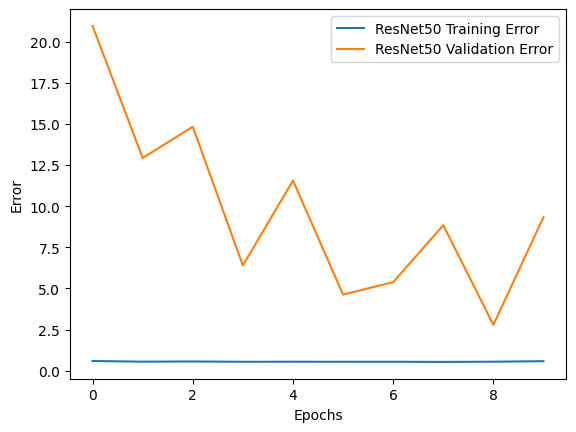

401/401 [==============================] - 940s 2s/step
ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4418
           1       0.66      1.00      0.79      8405

    accuracy                           0.66     12823
   macro avg       0.33      0.50      0.40     12823
weighted avg       0.43      0.66      0.52     12823



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Load the best model for ResNet50
best_resnet50_model = models.load_model('resnet50_best_model_new.h5')

# Plot training and validation errors vs. epochs
plt.plot(history_resnet50.history['loss'], label='ResNet50 Training Error')
plt.plot(history_resnet50.history['val_loss'], label='ResNet50 Validation Error')
# Show legend and plot
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

# Evaluate and print classification report for ResNet50
test_loss_resnet50, test_accuracy_resnet50 = resnet50_model.evaluate(tf_dataset_test)
predictions_resnet50 = resnet50_model.predict(tf_dataset_test)
predicted_labels_resnet50 = tf.argmax(predictions_resnet50, axis=1)
true_labels_resnet50 = tf.concat([y for x, y in tf_dataset_test], axis=0)
print("ResNet50 Classification Report:")
print(classification_report(true_labels_resnet50, predicted_labels_resnet50))

### MODEL PERFORMANCE

                   precision    recall  f1-score   support

           0       0.00      0.00      0.00      4418
           1       0.66      1.00      0.79      8405

    accuracy                           0.66     12823
    macro avg      0.33      0.50      0.40     12823
    weighted avg   0.43      0.66      0.52     12823

## SUMMARY
**CNN Model:**

  > Precision: 0.76
  > Recall: 0.76
  > F1-score: 0.75
  > Accuracy: 0.76

**EfficientNetB0 Transfer Learning:**

  >Precision: 0.57
  Recall: 0.65
  F1-score: 0.53
  Accuracy: 0.65

**ResNet50 Transfer Learning:**

  >Precision: 0.43
  Recall: 0.66
  F1-score: 0.52
  Accuracy: 0.66

**VGG16 Transfer Learning:**

  >Precision: 0.52
  Recall: 0.50
  F1-score: 0.51
  Accuracy: 0.50


*In summary, the CNN model performs the best overall with the highest precision, recall, and F1-score, resulting in the highest accuracy. The EfficientNetB0 Transfer Learning model has a lower performance compared to the CNN model, and ResNet50 Transfer Learning and VGG16 Transfer Learning models have the lowest accuracy among the models listed.*
